In [1]:
import os
os.environ["TF_NUM_THREADS"] = "0" # use all available CPU cores

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import numpy as np
import xarray as xr
import pandas as pd
import time

import diffxpy.api as de
from batchglm.api.models.nb_glm import Simulator

logging.getLogger("tensorflow").setLevel(logging.ERROR)
logging.getLogger("batchglm").setLevel(logging.WARNING)
logging.getLogger("diffxpy").setLevel(logging.WARNING)

logger = logging.getLogger(__name__)


In [2]:
def test_wilcoxon(sim):
    logger.info("test_wilcoxon started")
    start = time.time()
    test = de.test.wilcoxon(
        data=sim.X,
        grouping="condition",
        sample_description=sim.sample_description
    )
    end = time.time()
    logger.info("test_wilcoxon finished in %fs", (end - start))

    return test, (end - start)


def test_t_test(sim):
    logger.info("test_t_test started")
    start = time.time()
    test = de.test.t_test(
        data=sim.X,
        grouping="condition",
        sample_description=sim.sample_description
    )
    end = time.time()
    logger.info("test_t_test finished in %fs", (end - start))

    return test, (end - start)


def test_lrt(sim):
    logger.info("test_lrt started")
    start = time.time()
    test = de.test.lrt(
        data=sim.X,
        full_formula_loc="~ 1 + condition",
        full_formula_scale="~ 1 + condition",
        reduced_formula_loc="~ 1",
        reduced_formula_scale="~ 1",
        sample_description=sim.sample_description
    )
    end = time.time()
    logger.info("test_lrt finished in %fs", (end - start))

    return test, (end - start)


def test_wald_TF(sim):
    logger.info("test_wald_TF started")
    start = time.time()
    test = de.test.wald(
        data=sim.X,
        factor_loc_totest="condition",
        formula="~ 1 + condition",
        sample_description=sim.sample_description
    )
    end = time.time()
    logger.info("test_wald_TF finished in %fs", (end - start))

    return test, (end - start)


def test_wald_BFGS(sim):
    logger.info("test_wald_BFGS started")
    start = time.time()
    test = de.test.wald(
        data=sim.X,
        factor_loc_totest="condition",
        formula="~ 1 + condition",
        sample_description=sim.sample_description,
        training_strategy="BFGS",
    )
    end = time.time()
    logger.info("test_wald_BFGS finished in %fs", (end - start))

    return test, (end - start)


In [3]:
df = pd.DataFrame(columns=[
    "n_cells",
    "n_genes",
    "wilcoxon",
    "t_test",
    # "lrt",
    "wald_TF",
    "wald_BFGS",
])

n_genes = 1000
for n_cells in (1e3, 1e4, 1e5):
    n_cells = int(n_cells)
    logger.info("Running tests with n_cells=%d and n_genes=%d", n_cells, n_genes)
    
    sim = Simulator(num_observations=n_cells, num_features=n_genes)
    sim.generate_sample_description(num_batches=0)
    sim.generate()

    df = df.append({
        "n_cells": n_cells,
        "n_genes": n_genes,
        "wilcoxon": test_wilcoxon(sim)[1],
        "t_test": test_t_test(sim)[1],
        # "lrt": test_lrt(sim)[1],
        "wald_TF": test_wald_TF(sim)[1],
        "wald_BFGS": test_wald_BFGS(sim)[1] if n_genes * n_cells <= 1e6 else np.nan
    }, ignore_index=True)


Running tests with n_cells=1000 and n_genes=1000
test_wilcoxon started
test_wilcoxon finished in 0.357930s
test_t_test started
test_t_test finished in 0.012907s
test_wald_TF started
test_wald_TF finished in 11.736882s
test_wald_BFGS started


/usr/local/lib/python3.6/dist-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


test_wald_BFGS finished in 221.140826s
Running tests with n_cells=10000 and n_genes=1000
test_wilcoxon started
test_wilcoxon finished in 1.883970s
test_t_test started
test_t_test finished in 0.139356s
test_wald_TF started
test_wald_TF finished in 52.331453s
Running tests with n_cells=100000 and n_genes=1000
test_wilcoxon started
test_wilcoxon finished in 20.414381s
test_t_test started
test_t_test finished in 1.221701s
test_wald_TF started
test_wald_TF finished in 442.918566s


In [4]:
df

,n_cells,n_genes,wilcoxon,t_test,wald_TF,wald_BFGS
0,1000.0,1000.0,0.357930,0.012907,11.736882,221.140826
1,10000.0,1000.0,1.883970,0.139356,52.331453,NaN
2,100000.0,1000.0,20.414381,1.221701,442.918566,NaN


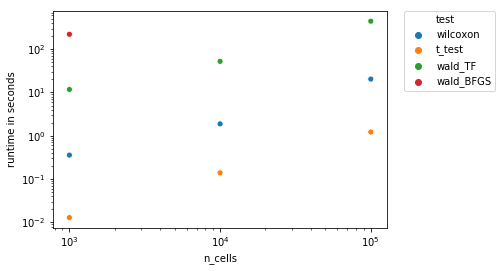

In [5]:
melted = pd.melt(df, id_vars=["n_genes", "n_cells"], var_name="test", value_name="runtime")

fig, ax = plt.subplots()
ax.set(xscale="log", yscale="log")

sns.scatterplot(data=melted, x="n_cells", y="runtime", hue="test", ax=ax)

ax.set(ylabel='runtime in seconds')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()